# Evolutionary Algorithms for Combinatorial Multi-Knapsack
## EA Functions
### Imports and Config

In [24]:
import time, array, random, copy, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re
from deap import algorithms, base, benchmarks, tools, creator
import seaborn

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

### Instance Creation

In [4]:


def ws_split_int(lst):
    lst = re.split(r'\s+', lst)
    lst.pop()        #remove first empty character
    lst.pop(0)       #remove last empty character
    lst = [int(x) for x in lst]
    return lst
def instance_create(file_name, m, pop_size, num_gen, mut_rate, xover_rate):
    with open(file_name) as f:
        lines = f.readlines()
    d = dict();
    d['ref'] = lines[0]
    num_of_vars = d['num_of_vars'] = int(lines[1])
    d['profits'] = np.asarray(ws_split_int(lines[2]))
    combinations = [ws_split_int(i) for i in lines[3:num_of_vars+2]]
    combi_length = max(map(len, combinations))
    d['combinations'] = np.array([[0]*(combi_length-len(xi))+xi for xi in combinations])
    d['constraint_type'] = lines[int(num_of_vars)+3]
    weights = np.asarray(ws_split_int(lines[num_of_vars+5]))
    d['weights'] = weights    
    d['capacity'] = math.floor((0.8 * sum(weights)) / m)
    d['mut_rate'] = mut_rate
    d['xover_rate'] = xover_rate
    d['num_gen'] = num_gen
    d['pop_size'] = pop_size
    d['n_kp'] = m
    return d


### Population Generation, Fitness, Mutation, and Xover

In [5]:
def eval_fitness(individual, instance):
    n_kp = instance.get("n_kp")
    num_of_vars = instance.get("num_of_vars")
    profits = instance.get("profits")
    combinations = instance.get("combinations")
    constraint_type = instance.get("constraint_type")
    capacity = int(instance.get("capacity"))
    weights = instance.get("weights")
    knapsacks_weight = [0]*n_kp
    knapsacks_profit = [0]*n_kp
    
    for i in range(len(individual)):
        if individual[i] != 0 and individual[i] <= n_kp:
            knapsack = individual[i] - 1
            knapsacks_weight[knapsack] += weights[i]
            knapsacks_profit[knapsack] += profits[i]
            for j in range(len(individual)):
                if knapsack == individual[j] - 1:
                    knapsacks_profit[knapsack] += combinations[i-1][j-1]
    f1 = 0
    f2 = sum(knapsacks_weight)
    f3 = min(knapsacks_profit)

    for i in range(n_kp):
        if knapsacks_weight[i] > capacity:
            f1 += knapsacks_profit[i] * (capacity / knapsacks_weight[i])
        else:
            f1 += knapsacks_profit[i]
    return f1, f2, f3

def uniform(low, m, n_kp):
    n = [0]*m
    for i in range(0,m):
        n[i] = random.randint(0,n_kp)
    return n

def favorite_child_xover(ind1, ind2):
    fit1 = ind1.fitness.values
    fit2 = ind2.fitness.values
    
    prob = fit1[0] / (fit1[0]+fit2[0])
    
    if fit1[0] > fit2[0]:
        prob = 1/prob
    
    size = min(len(ind1), len(ind2))
    
    for i in range(size):
        if random.random() > prob:
            ind1[i] = ind2[i]
            ind2[i] = ind1[i]
    return ind1, ind2

def mutation(x, n_kp):
    index = random.randrange(len(x))
    var = random.randint(0,n_kp)
    x[index] = var
    return x,


### Running EA

In [6]:
def run_ea(toolbox, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)
    population, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=toolbox.cx_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=True)
    return population, logbook

### Single Execution Script

In [105]:
def execute_EA(instance):
    creator.create("FitnessMin", base.Fitness, weights=(1.0,-1.0, 1.0))
    creator.create("Individual", list, typecode='i', 
                   fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    num_kp = instance.get("n_kp")
    toolbox.register("evaluate", lambda x: eval_fitness(x, instance))
    BOUND_LOW, BOUND_UP = 0, instance.get("num_of_vars")
    NDIM = 2
    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, num_kp)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    #toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
    toolbox.register("mate", favorite_child_xover)
    #toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
    toolbox.register("mutate", lambda x: mutation(x, num_kp),)
    toolbox.register("select", tools.selNSGA2)

    toolbox.pop_size = instance.get("pop_size")
    toolbox.max_gen = instance.get("num_gen")
    toolbox.mut_prob = instance.get("mut_rate")
    toolbox.cx_prob = instance.get("xover_rate")
    res,logbook = run_ea(toolbox)

    fronts = tools.emo.sortLogNondominated(res, len(res))
    plot_colors = seaborn.color_palette("Set1", n_colors=10)
    #fig, ax = plt.subplots(1, figsize=(4,4))
    fig = plt.figure()
    ax = Axes3D(fig)
    for i,inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)
        #df.plot3D(ax=ax, kind='scatter', label='Front ' + str(i+1), 
        #             x=df.columns[0], y=df.columns[1], z=df.columns[2],
        #             color=plot_colors[i])
        df = df.rename(columns={0: "x", 1: "y", 2: "z"})
        print(df)
        ax.scatter3D(df.x, df.y, df.y, label='Front'+str(i+1), color=plot_colors[i])
    ax.legend()
    ax.set_xlabel('$f_1(\mathbf{x})$');ax.set_ylabel('$f_2(\mathbf{x})$');ax.set_zlabel('$f_3(\mathbf{x})$')
    return res,logbook, fronts

### Multiple Instance Testing Function

In [ ]:
### TODO: Make this function

## Running and Testing
### Single Execution

gen	nevals	max    	avg    
0  	50    	16626.6	5954.54
1  	43    	16626.6	6159.51
2  	45    	16626.6	6275.73
3  	44    	16626.6	6430.5 
4  	42    	16626.6	6435.89
5  	41    	17511  	6190.19
6  	46    	17511  	6244.1 
7  	42    	17511  	6221.08
8  	39    	17511  	6440.19
9  	42    	17511  	6573.55
10 	44    	17511  	6688.89
               x     y     z
0   17511.000000  1978  5104
1   17511.000000  1978  5104
2   17002.000000  1973  5011
3   16654.000000  1955  5011
4   16654.000000  1955  5011
5   16404.000000  1947  4761
6   16404.000000  1947  4761
7   16205.822819  1880  3468
8   15861.735871  1945  3906
9   15861.735871  1945  3906
10  15732.701449  2064  5151
11  15732.701449  2064  5151
12  15732.701449  2064  5151
13  15666.832241  1922  3735
14  15622.069565  2020  5151
15  15622.069565  2020  5151
16  15617.997135  1858  2936
17  15576.262108  1843  3437
18  15375.000000  1776  2480
19  15329.626234  1762  2523
20  15096.031088  1848  4042
21  14944.111111  1853  4721
22  14843

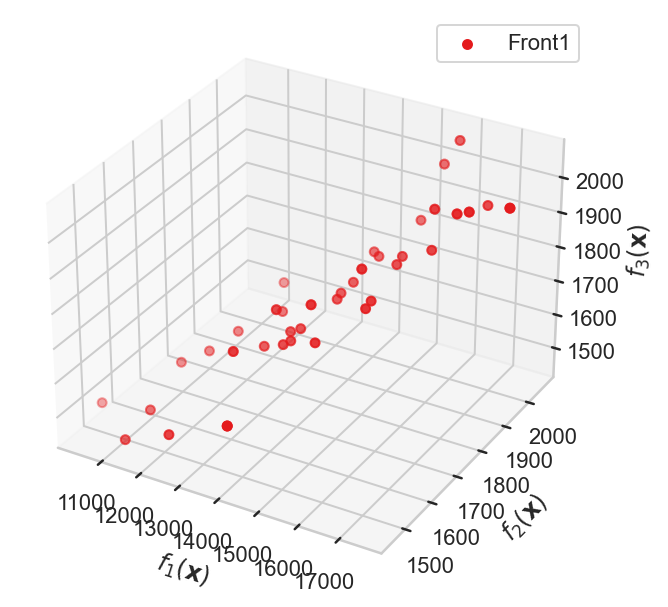

In [106]:
#file_name, m, pop_size, num_gen, mut_rate, xover_rate
instance = instance_create('jeu_100_25_1.txt', 3, 50, 10, .05, .8)
%time res, logbook, fronts = execute_EA(instance)

### Generating Instances

In [31]:
### TODO: create function to generate all the instances we need for testing


117
